In [2]:
# essentials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from collections import Counter
import pickle

## Dense NN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout

# train test split 
from sklearn.model_selection import train_test_split

# my files
import config
from utils.DataGenerator import DataGenerator

In [3]:
small_data = True
seed = 42

In [4]:
try:
    os.makedirs(config.NN_MODEL_DIR)
except(FileExistsError):
    print(f"WARNING: You will may overwrite your models, because directory \"{config.NN_MODEL_DIR}\" already exists.")

## Load the data

In [5]:
if small_data:
    data_path = "data/reviews_cleaned_sample.csv"
    vocabulary_filename = "vocabulary_small.pkl"
else:
    data_path = "data/reviews_cleaned.csv"
    vocabulary_filename = "vocabulary.pkl"

reviews_df = pd.read_csv(data_path, converters={'tokenized': pd.eval})

Since I am using the whole dataset to create word2vec I can use the same one every time, regardless to the sample I take to train the NN

In [6]:
with open("models/word2vec-general.pkl", "rb") as file:
    word2vec = pickle.load(file)

## Creating the dataset

In [7]:
data_generator = DataGenerator(reviews_df.tokenized)

In [8]:
data_generator.create_vocabulary(min_count=config.VOCAB_MIN_COUNT, extra_tokens=[config.END_TOKEN])
vocabulary_size = len(data_generator.vocabulary)

In [9]:
X_words, y_words = data_generator.create_dataset(previous_words_considered=config.PREVIOUS_WORDS_CONSIDERED)

In [14]:
X = data_generator.vectorize(X_words, word_fievectorizer=word2vec, input_size=config.INPUT_SIZE)

In [15]:
# one hot the labels
label_to_index = {word: index for index, word in enumerate(data_generator.vocabulary)}

y = np.zeros((len(y_words), len(data_generator.vocabulary)))

# instead of using for example to_categorical from tensorflow
# to make it more efficient 
for index, label in enumerate(y_words):
    y[index, label_to_index[label]] += 1

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=seed)

## Dense NN model

In [17]:
model = Sequential()

model.add(Input(config.INPUT_SIZE))
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))


model.add(Dense(vocabulary_size, activation="sigmoid"))

model.build()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              615424    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 1046)              5

In [18]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=config.LABEL_SMOOTHING_RATIO)
optimizer = tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)

In [19]:
model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])

In [20]:
# patience and start_from_epochs depending on the epochs number
# patience 10% of the total number of epochs
# start_from_epochs 5% of the total number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=int(config.EPOCHS*0.10), 
                                                start_from_epoch=(config.EPOCHS*0.05),
                                                min_delta=0.001,
                                                restore_best_weights=True,
                                                verbose=1) 

In [21]:
training = model.fit(X_train, y_train, validation_split=0.1, batch_size=config.BATCH_SIZE, epochs=config.EPOCHS, callbacks=[early_stopping])

Epoch 1/64
499/499 [==============================] - 14s 26ms/step - loss: 5.6335 - acc: 0.1045 - val_loss: 5.4469 - val_acc: 0.1335
Epoch 2/64
499/499 [==============================] - 14s 27ms/step - loss: 5.2374 - acc: 0.1396 - val_loss: 5.2023 - val_acc: 0.1459
Epoch 3/64
499/499 [==============================] - 14s 28ms/step - loss: 5.0820 - acc: 0.1503 - val_loss: 5.1072 - val_acc: 0.1555
Epoch 4/64
499/499 [==============================] - 14s 29ms/step - loss: 4.9890 - acc: 0.1575 - val_loss: 5.0302 - val_acc: 0.1619
Epoch 5/64
499/499 [==============================] - 14s 27ms/step - loss: 4.9196 - acc: 0.1648 - val_loss: 4.9922 - val_acc: 0.1642
Epoch 6/64
499/499 [==============================] - 14s 28ms/step - loss: 4.8618 - acc: 0.1726 - val_loss: 4.9513 - val_acc: 0.1707
Epoch 7/64
499/499 [==============================] - 14s 28ms/step - loss: 4.8071 - acc: 0.1779 - val_loss: 4.9432 - val_acc: 0.1691
Epoch 8/64
499/499 [==============================] - 14s 28ms

In [22]:
loss, acc = model.evaluate(X_test, y_test)

247/247 [==============================] - 2s 9ms/step - loss: 4.9122 - acc: 0.1689


In [23]:
acc = int(acc * 100)
model_filename = f"dense-lr{config.LEARNING_RATE}-batch{config.BATCH_SIZE}-acc{acc}.h5"

model.save(os.path.join(config.NN_MODEL_DIR, model_filename))

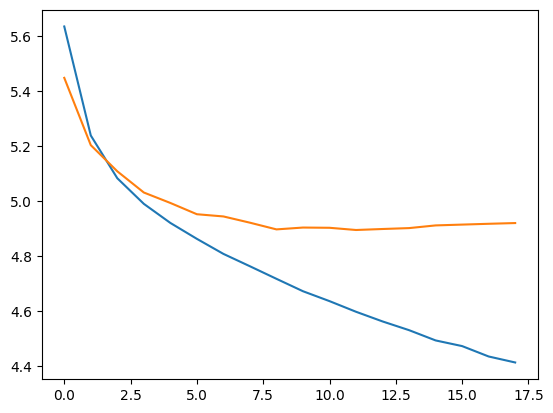

In [24]:
# due to early stopping executed epochs might be different
executed_epochs = len(training.history["loss"])

plt.plot(range(executed_epochs), training.history["loss"])
plt.plot(range(executed_epochs), training.history["val_loss"])